In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

# For display
pd.set_option('display.max_columns', None)

## Patient Segmentation

In [41]:
full_df =pd.read_csv(r"C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets\processed_patient_segmentation\full_df.csv")

In [42]:
# --- defining the variables

numerical_features = [
    'age', 'bmi',
    'pain_level_mean', 'avg_satisfaction', 'avg_home_adherence',
    'adherence_variability', 'pain_delta', 'pain_pct_change'
]


categorical_features = [
    'gender', 'smoker', 'chronic_cond', 'injury_type'
]


# Convert categorical features to string

full_df[categorical_features] = full_df[categorical_features].astype("string")

## Preprocessing Pipeline

In [43]:
# ---- build a preprocessing pipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])


categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# --- put them together
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

In [44]:
pat_clust = preprocessor.fit_transform(full_df)

In [45]:
# -- auto dimension reduction
# -- PCA to help retain the variance of features
from sklearn.decomposition import PCA

pca = PCA (n_components=0.85, random_state=45)

x_reduced = pca.fit_transform(pat_clust)

## K Means Clustering

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def evaluate_kmeans(X, k_range=range(2, 12), random_state=42):
    wcss = []
    sils = []
    
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        preds = km.fit_predict(x_reduced)
        
        # Inertia = Within-Cluster Sum of Squares (rubber band effect)
        wcss.append(km.inertia_)
        
        # Silhouette Score
        score = silhouette_score(x_reduced, preds)
        sils.append(score)
        
        print(f"K={k}: Inertia={km.inertia_:.2f}, Silhouette={score:.4f}")
    
    # Plotting
    plt.figure(figsize=(12, 5))

    # Rubber band effect (Inertia)
    plt.subplot(1, 2, 1)
    plt.plot(k_range, wcss, marker='o')
    plt.title("Elbow Method (Inertia)")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("WCSS (Inertia)")
    
    # Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(k_range, sils, marker='s', color='green')
    plt.title("Silhouette Scores")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    
    plt.tight_layout()
    plt.show()
    
    return wcss, sils

K=2: Inertia=24325.57, Silhouette=0.1571
K=3: Inertia=22393.72, Silhouette=0.0998
K=4: Inertia=20341.12, Silhouette=0.1274
K=5: Inertia=19046.13, Silhouette=0.1127
K=6: Inertia=18096.98, Silhouette=0.1070
K=7: Inertia=17356.97, Silhouette=0.1005
K=8: Inertia=16865.11, Silhouette=0.0943
K=9: Inertia=16411.24, Silhouette=0.0964
K=10: Inertia=15944.52, Silhouette=0.1011
K=11: Inertia=15563.76, Silhouette=0.1017


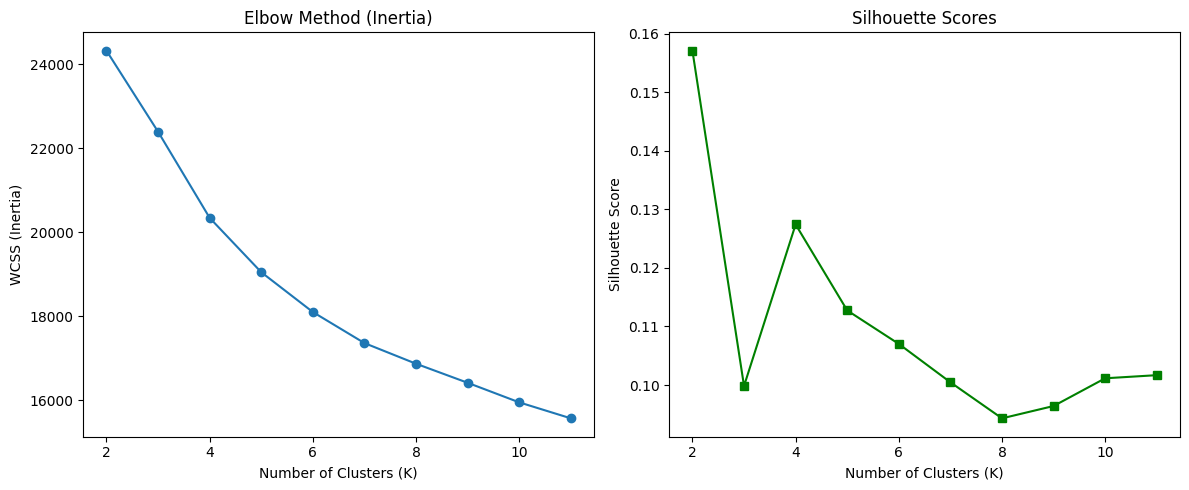

In [47]:
wcss, sils = evaluate_kmeans(x_reduced)

In [48]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.neighbors import NearestNeighbors
k_opt =4

kmeans = KMeans(n_clusters=k_opt,n_init='auto',algorithm='lloyd',
                 random_state=42)

clusters = kmeans.fit_predict(x_reduced)

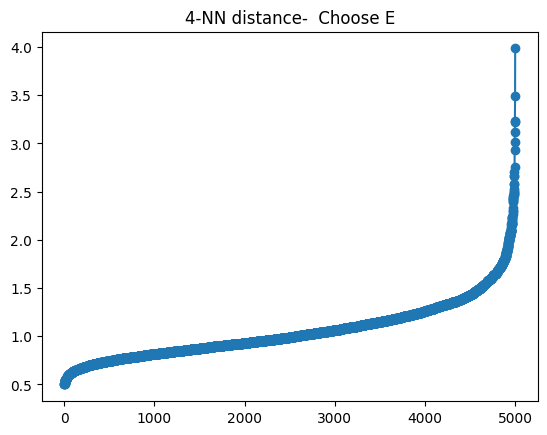

In [49]:
# ---DBSCAN

knn =NearestNeighbors(n_neighbors=k_opt).fit(x_reduced)
dists = np.sort(knn.kneighbors(x_reduced)[0][:,-1])

plt.figure; plt.plot(dists,'o-'); plt.title("4-NN distance-  Choose E"); plt.show()

DBSCAN valid-cluster silhouette: 0.297


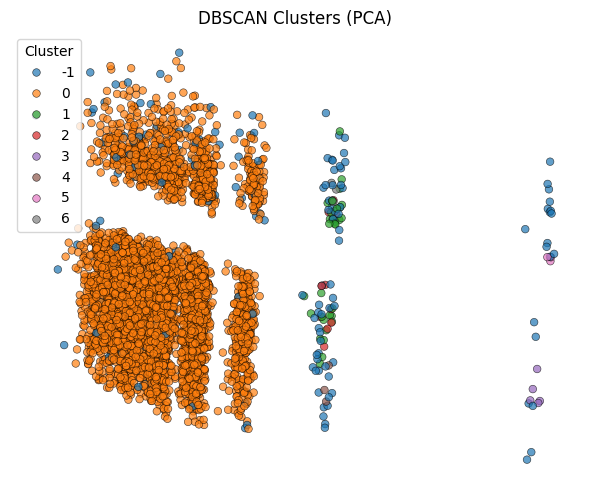

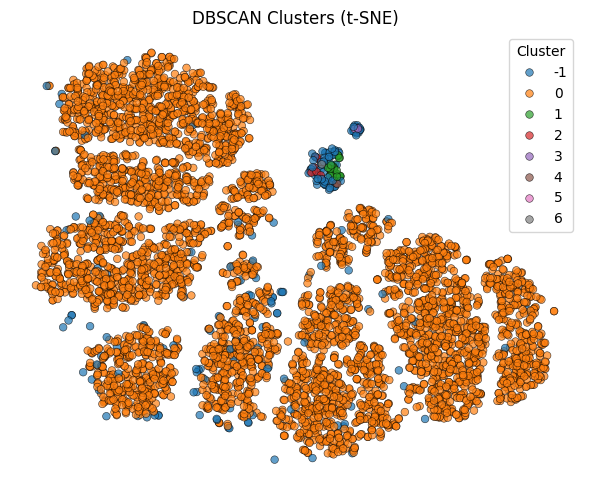

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- DBSCAN Clustering ---
db = DBSCAN(eps=1.5, min_samples=3).fit(x_reduced)
db_labels = db.labels_

# --- Silhouette Score (excluding noise) ---
if len(set(db_labels)) > 1 and len(set(db_labels)) != 1 + (1 if -1 in db_labels else 0):
    sil_db = silhouette_score(pat_clust[db_labels != -1], db_labels[db_labels != -1])
    print(f"DBSCAN valid-cluster silhouette: {sil_db:.3f}")
else:
    print("Silhouette score not applicable: less than 2 valid clusters.")
    sil_db = None

# --- Dimensionality Reduction for Visualization ---
pca_2d = PCA(n_components=2, random_state=42).fit_transform(x_reduced)
tsne_2d = TSNE(n_components=2, perplexity=40, init="pca", random_state=42).fit_transform(x_reduced)


# --- Plot Function ---
def scatter_2d(mat, labels, title):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=mat[:, 0], y=mat[:, 1], hue=labels, palette='tab10', s=30, alpha=0.7, edgecolor='k')
    plt.title(title)
    plt.axis('off')
    plt.legend(loc='best', title='Cluster')
    plt.tight_layout()
    plt.show()

# --- Visualize Clusters ---
scatter_2d(pca_2d, db_labels, "DBSCAN Clusters (PCA)")
scatter_2d(tsne_2d, db_labels, "DBSCAN Clusters (t-SNE)")